In [1]:
!pip3 install pandas
!pip3 install seaborn
!pip3 install --upgrade tensorflow-gpu
!pip3 install import-ipynb

from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import math
import pickle
import time
import sys

import import_ipynb
import VariationalAutoencoderModel

import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Lambda, Input, Dense
from tensorflow.keras.losses import mse
from tensorflow.keras import optimizers
from tensorflow.keras import backend as K

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, mean_squared_error, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

%matplotlib inline

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


Defaulting to user installation because normal site-packages is not writeable
importing Jupyter notebook from VariationalAutoencoderModel.ipynb
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


2022-04-27 17:19:37.219034: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-27 17:19:37.219056: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction = 0.333)
sess = tf.compat.v1.Session(config = tf.compat.v1.ConfigProto(gpu_options = gpu_options))

2022-04-27 17:19:38.248705: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-27 17:19:38.276559: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-27 17:19:38.276664: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-04-27 17:19:38.276747: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared obj

# Provision 838 Camera Data Pre-Processing

In [3]:
# Benign traffic

p8_benign = pd.read_csv('nbaiot/Provision_PT_838_Security_Camera/benign_traffic.csv', encoding = "utf-8", sep = ',' ) 
df_p8_benign = p8_benign.copy(deep=True)

columns = list(df_p8_benign.columns)
chosen_columns = []
for column in columns:
    if column.find('L5') != -1:
        chosen_columns.append(column)
        
df_p8_benign = pd.DataFrame(df_p8_benign, columns = chosen_columns)  

# Mirai

p8_mirai_ack = pd.read_csv('nbaiot/Provision_PT_838_Security_Camera/mirai/ack.csv', encoding = "utf-8", sep = ',' ) 
df_p8_mirai_ack = p8_mirai_ack.copy(deep=True)
df_p8_mirai_ack = pd.DataFrame(df_p8_mirai_ack, columns = chosen_columns) 

p8_mirai_scan = pd.read_csv('nbaiot/Provision_PT_838_Security_Camera/mirai/scan.csv', encoding = "utf-8", sep = ',' ) 
df_p8_mirai_scan = p8_mirai_scan.copy(deep=True)
df_p8_mirai_scan = pd.DataFrame(df_p8_mirai_scan, columns = chosen_columns) 

p8_mirai_syn = pd.read_csv('nbaiot/Provision_PT_838_Security_Camera/mirai/syn.csv', encoding = "utf-8", sep = ',' ) 
df_p8_mirai_syn = p8_mirai_syn.copy(deep=True)
df_p8_mirai_syn = pd.DataFrame(df_p8_mirai_syn, columns = chosen_columns) 

p8_mirai_udp = pd.read_csv('nbaiot/Provision_PT_838_Security_Camera/mirai/udp.csv', encoding = "utf-8", sep = ',' ) 
df_p8_mirai_udp = p8_mirai_udp.copy(deep=True)
df_p8_mirai_udp = pd.DataFrame(df_p8_mirai_udp, columns = chosen_columns) 

p8_mirai_udpplain = pd.read_csv('nbaiot/Provision_PT_838_Security_Camera/mirai/udpplain.csv', encoding = "utf-8", sep = ',' ) 
df_p8_mirai_udpplain = p8_mirai_udpplain.copy(deep=True)
df_p8_mirai_udpplain = pd.DataFrame(df_p8_mirai_udpplain, columns = chosen_columns) 

# Bashlite

p8_bashlite_combo = pd.read_csv('nbaiot/Provision_PT_838_Security_Camera/gafgyt/combo.csv', encoding = "utf-8", sep = ',' ) 
df_p8_bashlite_combo = p8_bashlite_combo.copy(deep=True)
df_p8_bashlite_combo = pd.DataFrame(df_p8_bashlite_combo, columns = chosen_columns) 

p8_bashlite_junk = pd.read_csv('nbaiot/Provision_PT_838_Security_Camera/gafgyt/junk.csv', encoding = "utf-8", sep = ',' ) 
df_p8_bashlite_junk = p8_bashlite_junk.copy(deep=True)
df_p8_bashlite_junk = pd.DataFrame(df_p8_bashlite_junk, columns = chosen_columns)

p8_bashlite_scan = pd.read_csv('nbaiot/Provision_PT_838_Security_Camera/gafgyt/scan.csv', encoding = "utf-8", sep = ',' ) 
df_p8_bashlite_scan = p8_bashlite_scan.copy(deep=True)
df_p8_bashlite_scan = pd.DataFrame(df_p8_bashlite_scan, columns = chosen_columns)

p8_bashlite_udp = pd.read_csv('nbaiot/Provision_PT_838_Security_Camera/gafgyt/udp.csv', encoding = "utf-8", sep = ',' ) 
df_p8_bashlite_udp = p8_bashlite_udp.copy(deep=True)
df_p8_bashlite_udp = pd.DataFrame(df_p8_bashlite_udp, columns = chosen_columns)

p8_bashlite_tcp = pd.read_csv('nbaiot/Provision_PT_838_Security_Camera/gafgyt/tcp.csv', encoding = "utf-8", sep = ',' ) 
df_p8_bashlite_tcp = p8_bashlite_tcp.copy(deep=True)
df_p8_bashlite_tcp = pd.DataFrame(df_p8_bashlite_tcp, columns = chosen_columns)

In [4]:
scaler = MinMaxScaler()
df_p8_benign_norm = scaler.fit_transform(df_p8_benign)

df_p8_miraiack_norm = scaler.fit_transform(df_p8_mirai_ack)
df_p8_miraiscan_norm = scaler.fit_transform(df_p8_mirai_scan)
df_p8_miraisyn_norm = scaler.fit_transform(df_p8_mirai_syn)
df_p8_miraiudp_norm = scaler.fit_transform(df_p8_mirai_udp)
df_p8_miraiudpplain_norm = scaler.fit_transform(df_p8_mirai_udpplain)

df_p8_bashlitecombo_norm = scaler.fit_transform(df_p8_bashlite_combo)
df_p8_bashlitejunk_norm = scaler.fit_transform(df_p8_bashlite_junk)
df_p8_bashlitescan_norm = scaler.fit_transform(df_p8_bashlite_scan)
df_p8_bashliteudp_norm = scaler.fit_transform(df_p8_bashlite_udp)
df_p8_bashlitetcp_norm = scaler.fit_transform(df_p8_bashlite_tcp)

# Variational Autoencoder - Attack Detection

## Model

In [5]:
# Train set

len_benign = len(df_p8_benign_norm)
len_benign_train = int(0.7 * len_benign)
X_train_VAE = df_p8_benign_norm[:len_benign_train]

# Test set - 30% benign and the rest is attack

X_test_benign = df_p8_benign_norm[len_benign_train:]

len_attack_test = len(X_test_benign)
X_test_mirai_ack = df_p8_miraiack_norm
X_test_mirai_scan = df_p8_miraiscan_norm
X_test_mirai_syn = df_p8_miraisyn_norm
X_test_mirai_udp = df_p8_miraiudp_norm
X_test_mirai_udpplain = df_p8_miraiudpplain_norm
X_test_bashlite_combo = df_p8_bashlitecombo_norm
X_test_bashlite_junk = df_p8_bashlitejunk_norm
X_test_bashlite_scan = df_p8_bashlitescan_norm
X_test_bashlite_tcp = df_p8_bashlitetcp_norm
X_test_bashlite_udp = df_p8_bashliteudp_norm

X_test_VAE = np.concatenate([X_test_benign, X_test_mirai_ack, X_test_mirai_scan, X_test_mirai_syn, X_test_mirai_udp,
                             X_test_mirai_udpplain, X_test_bashlite_combo, X_test_bashlite_junk, X_test_bashlite_scan,
                             X_test_bashlite_tcp, X_test_bashlite_udp])

Y_test_VAE = np.ones(len(X_test_VAE))
Y_test_VAE[:len(X_test_benign)] = 0

In [6]:
# KL Loss function

def vae_loss(x, x_decoded_mean):
    # Compute the average MSE error, then scale it up (sum on all axes)
    
    reconstruction_loss = K.sum(K.square(x - x_decoded_mean))
    
    # Compute the KL loss
    
    kl_loss = - 0.5 * K.sum(1 + z_var - K.square(z_mean) - K.square(K.exp(z_var)), axis=-1)
    
    # Return the average loss over all 
    
    total_loss = K.mean(reconstruction_loss + kl_loss) # Total_loss = reconstruction_loss + kl_loss 
    return total_loss

# (1) Reconstruction Loss - Forces the encoder to generate latent features that minimize the reconstruction error, or else is
# penalized
# (2) KL Loss - Forces the distribution generated by the encoder to be similar to the prior probability of the input vector, 
# pushing latent feature space to normality

In [7]:
# Parameters

original_dim = X_train_VAE.shape[1]
input_shape = (original_dim,)
intermediate_dim = int(original_dim / 2)
latent_dim = int(original_dim / 3)

epochs = 450
learning_rate = 0.0001
batch_size = 43
anomaly_threshold = 0.038
number_features = 46

In [8]:
# Encoder

inputs, encoder, z_var, z_mean = VariationalAutoencoderModel.vae_encoder(
    input_shape, 
    intermediate_dim, 
    latent_dim, 
    VariationalAutoencoderModel.sample)

encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 23)]         0           []                               
                                                                                                  
 dense (Dense)                  (None, 11)           264         ['encoder_input[0][0]']          
                                                                                                  
 z_mean (Dense)                 (None, 7)            84          ['dense[0][0]']                  
                                                                                                  
 z_var (Dense)                  (None, 7)            84          ['dense[0][0]']                  
                                                                                            

In [9]:
# Decoder

decoder = VariationalAutoencoderModel.vae_decoder(
    intermediate_dim,
    latent_dim,
    original_dim)

decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z_sampling (InputLayer)     [(None, 7)]               0         
                                                                 
 dense_1 (Dense)             (None, 11)                88        
                                                                 
 dense_2 (Dense)             (None, 23)                276       
                                                                 
Total params: 364
Trainable params: 364
Non-trainable params: 0
_________________________________________________________________


In [10]:
# VAE model

outputs = decoder(encoder(inputs))

opt = optimizers.Adam(learning_rate = learning_rate, clipvalue = 0.5)

vae_model = Model(inputs, outputs, name = 'vae_mlp')
vae_model.compile(optimizer = opt, loss = vae_loss)
vae_model.summary()

Model: "vae_mlp"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 23)]              0         
                                                                 
 encoder (Functional)        (None, 7)                 432       
                                                                 
 decoder (Functional)        (None, 23)                364       
                                                                 
Total params: 796
Trainable params: 796
Non-trainable params: 0
_________________________________________________________________


## Train

In [11]:
train_start = time.time()

results = vae_model.fit(X_train_VAE, X_train_VAE,
                        shuffle = True,
                        epochs = epochs,
                        batch_size = batch_size)

train_end = time.time()
train_time = train_end - train_start
print("Training time:", train_time)

Train on 68959 samples
Epoch 1/450
   43/68959 [..............................] - ETA: 4:54 - loss: 224.8801

2022-04-27 17:19:47.718517: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


68959/68959 [==============================] - 3s 43us/sample - loss: 136.4546
Epoch 2/450
68959/68959 [==============================] - 3s 41us/sample - loss: 31.4104
Epoch 3/450
68959/68959 [==============================] - 3s 41us/sample - loss: 14.8369
Epoch 4/450
68959/68959 [==============================] - 3s 41us/sample - loss: 12.0780
Epoch 5/450
68959/68959 [==============================] - 3s 41us/sample - loss: 10.5824
Epoch 6/450
68959/68959 [==============================] - 3s 41us/sample - loss: 9.0474
Epoch 7/450
68959/68959 [==============================] - 3s 41us/sample - loss: 7.6610
Epoch 8/450
68959/68959 [==============================] - 3s 41us/sample - loss: 6.7567
Epoch 9/450
68959/68959 [==============================] - 3s 41us/sample - loss: 6.2307
Epoch 10/450
68959/68959 [==============================] - 3s 41us/sample - loss: 5.8279
Epoch 11/450
68959/68959 [==============================] - 3s 41us/sample - loss: 5.5220
Epoch 12/450
68959/68959 

68959/68959 [==============================] - 4s 54us/sample - loss: 3.0539
Epoch 93/450
68959/68959 [==============================] - 4s 54us/sample - loss: 3.0453
Epoch 94/450
68959/68959 [==============================] - 4s 54us/sample - loss: 3.0648
Epoch 95/450
68959/68959 [==============================] - 4s 54us/sample - loss: 3.0610
Epoch 96/450
68959/68959 [==============================] - 4s 54us/sample - loss: 3.0563
Epoch 97/450
68959/68959 [==============================] - 4s 54us/sample - loss: 3.0595
Epoch 98/450
68959/68959 [==============================] - 4s 54us/sample - loss: 3.0482
Epoch 99/450
68959/68959 [==============================] - 4s 54us/sample - loss: 3.0536
Epoch 100/450
68959/68959 [==============================] - 4s 54us/sample - loss: 3.0349
Epoch 101/450
68959/68959 [==============================] - 4s 54us/sample - loss: 3.0661
Epoch 102/450
68959/68959 [==============================] - 4s 54us/sample - loss: 3.0629
Epoch 103/450
68959/

68959/68959 [==============================] - 4s 54us/sample - loss: 2.9991
Epoch 183/450
68959/68959 [==============================] - 4s 54us/sample - loss: 2.9865
Epoch 184/450
68959/68959 [==============================] - 4s 54us/sample - loss: 2.9888
Epoch 185/450
68959/68959 [==============================] - 4s 54us/sample - loss: 2.9812
Epoch 186/450
68959/68959 [==============================] - 4s 54us/sample - loss: 2.9736
Epoch 187/450
68959/68959 [==============================] - 4s 54us/sample - loss: 2.9906
Epoch 188/450
68959/68959 [==============================] - 4s 54us/sample - loss: 2.9864
Epoch 189/450
68959/68959 [==============================] - 4s 54us/sample - loss: 2.9861
Epoch 190/450
68959/68959 [==============================] - 4s 54us/sample - loss: 2.9767
Epoch 191/450
68959/68959 [==============================] - 4s 54us/sample - loss: 2.9746
Epoch 192/450
68959/68959 [==============================] - 4s 54us/sample - loss: 2.9820
Epoch 193/450

68959/68959 [==============================] - 4s 54us/sample - loss: 3.0227
Epoch 273/450
68959/68959 [==============================] - 4s 54us/sample - loss: 3.0009
Epoch 274/450
68959/68959 [==============================] - 4s 54us/sample - loss: 3.0241
Epoch 275/450
68959/68959 [==============================] - 4s 54us/sample - loss: 3.0250
Epoch 276/450
68959/68959 [==============================] - 4s 54us/sample - loss: 3.0233
Epoch 277/450
68959/68959 [==============================] - 4s 54us/sample - loss: 3.0313
Epoch 278/450
68959/68959 [==============================] - 4s 54us/sample - loss: 3.0218
Epoch 279/450
68959/68959 [==============================] - 4s 54us/sample - loss: 3.0171
Epoch 280/450
68959/68959 [==============================] - 4s 54us/sample - loss: 3.0218
Epoch 281/450
68959/68959 [==============================] - 4s 54us/sample - loss: 3.0343
Epoch 282/450
68959/68959 [==============================] - 4s 54us/sample - loss: 3.0346
Epoch 283/450

68959/68959 [==============================] - 4s 53us/sample - loss: 2.9784
Epoch 363/450
68959/68959 [==============================] - 4s 54us/sample - loss: 2.9693
Epoch 364/450
68959/68959 [==============================] - 4s 54us/sample - loss: 2.9782
Epoch 365/450
68959/68959 [==============================] - 4s 54us/sample - loss: 2.9931
Epoch 366/450
68959/68959 [==============================] - 4s 54us/sample - loss: 2.9883
Epoch 367/450
68959/68959 [==============================] - 4s 54us/sample - loss: 2.9867
Epoch 368/450
68959/68959 [==============================] - 4s 54us/sample - loss: 2.9844
Epoch 369/450
68959/68959 [==============================] - 4s 54us/sample - loss: 3.0012
Epoch 370/450
68959/68959 [==============================] - 4s 54us/sample - loss: 2.9998
Epoch 371/450
68959/68959 [==============================] - 4s 54us/sample - loss: 2.9943
Epoch 372/450
68959/68959 [==============================] - 4s 54us/sample - loss: 2.9919
Epoch 373/450

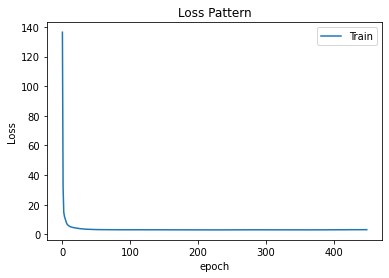

In [12]:
plt.plot(results.history['loss'])
plt.title('Loss Pattern')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper right');
plt.show()

## Test

In [13]:
X_train_pred = vae_model.predict(X_train_VAE)
error_vector = VariationalAutoencoderModel.get_error_term(X_train_pred, X_train_VAE, _rmse=False)
error_thresh = anomaly_threshold
#np.quantile(error_vector, anomaly_threshold)

# Measure the error between the train set and its output and generates an error vector representing the error of each term
# Find an extreme value on the vector to use as the error threshold

/home/andressa.amaral/.local/lib/python3.7/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [14]:
test_start = time.time()

X_pred_VAE = vae_model.predict(X_test_VAE)

test_end = time.time()
test_time = test_end - test_start
print("Testing time:", test_time)

# If the error of the vector is higher than the defined threshold it detects an attack

error_vector = VariationalAutoencoderModel.get_error_term(X_pred_VAE, X_test_VAE, _rmse=False)
attacks = (error_vector > error_thresh)
print(attacks)

np.count_nonzero(attacks) / len(attacks) # Percentage of attacks

Testing time: 25.178335666656494
[False False False ...  True  True  True]


0.9651114942468865

In [15]:
print(len(X_test_VAE))

767932


## Metrics

In [16]:
sys.stdout = open("Results/P838_camera.txt", "a")

print(" ==== Test " + str(number_features) + " Normal learning rate ====")
print("Training time:" + str(train_time))
print("Testing time:" + str(test_time))
print(classification_report(Y_test_VAE, attacks, digits = 5))

In [17]:
'''# Examinig the latent space generated by the encoder

X_encoded = encoder.predict(X_test_VAE)

pca = PCA(n_components=2)
X_analysis = pca.fit_transform(X_encoded)'''

'# Examinig the latent space generated by the encoder\n\nX_encoded = encoder.predict(X_test_VAE)\n\npca = PCA(n_components=2)\nX_analysis = pca.fit_transform(X_encoded)'

In [18]:
'''plt.figure(figsize = (12, 10))
sns.scatterplot(x = X_analysis[:, 0], y = X_analysis[:, 1], s = 20, hue = error_vector)
plt.grid()
plt.show()

# Darker clusters indicate that the error is higher'''

'plt.figure(figsize = (12, 10))\nsns.scatterplot(x = X_analysis[:, 0], y = X_analysis[:, 1], s = 20, hue = error_vector)\nplt.grid()\nplt.show()\n\n# Darker clusters indicate that the error is higher'

In [19]:
'''plt.figure(figsize=(12, 10))
sns.scatterplot(x = X_analysis[:, 0], y = X_analysis[:, 1], s = 20, hue = attacks)
plt.grid()
plt.show()

# Orange ones are anomalies'''

'plt.figure(figsize=(12, 10))\nsns.scatterplot(x = X_analysis[:, 0], y = X_analysis[:, 1], s = 20, hue = attacks)\nplt.grid()\nplt.show()\n\n# Orange ones are anomalies'

In [20]:
'''plt.figure(figsize = (12, 10))
sns.scatterplot(x = X_analysis[:, 0], y = X_analysis[:, 1], s = 20, hue = Y_test_VAE)
plt.grid()
plt.show()

# Ground truth'''

'plt.figure(figsize = (12, 10))\nsns.scatterplot(x = X_analysis[:, 0], y = X_analysis[:, 1], s = 20, hue = Y_test_VAE)\nplt.grid()\nplt.show()\n\n# Ground truth'